In [1]:
from skimage import io, color
from skimage.transform import resize

# Load image and resize

In [2]:
m = n = 256
size = m * n

src = io.imread("pexelA-0.png")
tar = io.imread("pexelB-0.png")

src = resize(src, (m, n))
tar = resize(tar, (m, n))

# Show original two images

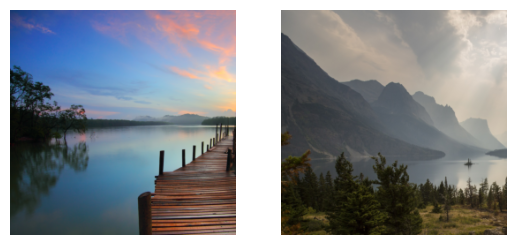

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
axs[0].imshow(src)
axs[1].imshow(tar)
axs[0].set_axis_off()
axs[1].set_axis_off()

# Convert to lab color space

In [4]:
src_lab = color.rgb2lab(src)
tar_lab = color.rgb2lab(tar)

# Split luminance channel and 'ab' channels

In [5]:
src_lumi = src_lab[:, :, 0]
src_ab = src_lab[:, :, 1:]

tar_lumi = tar_lab[:, :, 0]
tar_ab = tar_lab[:, :, 1:]

# Convert 'ab' channels to 2D NumPy arrays

In [6]:
import numpy as np

src_ab = np.reshape(src_ab, (-1, 2), order='F')
tar_ab = np.reshape(tar_ab, (-1, 2), order='F')

# Use KMeans to cluster 'ab' values

In [7]:
from sklearn.cluster import KMeans

clusters = 128
union_ab = np.vstack([src_ab, tar_ab])
kmeans = KMeans(n_clusters=clusters, random_state=0, n_init="auto").fit(union_ab)

OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set the environment variable OPENBLAS_NUM_THREADS to 64 or lower


In [8]:
sorted_a = np.array(sorted(kmeans.cluster_centers_[:, 0], reverse=True))
sorted_b = np.array(sorted(kmeans.cluster_centers_[:, 1]))

# Create a 'ab' plane and map each cluster center to a point

In [ ]:
grids = np.zeros((clusters, clusters, 2))

for i in range(clusters):
    for j in range(clusters):
        grids[i][j] = [sorted_b[j], sorted_a[i]]
        
grids = np.reshape(grids, (-1, 2), order='F')

cluster_to_bin = np.zeros(clusters)			# map each cluster center to a unique bin index of the created 'ab' plane

for i in range(clusters):
    for j in range(grids.shape[0]):
        if kmeans.cluster_centers_[i][0] == grids[j][1] and kmeans.cluster_centers_[i][1] == grids[j][0]:
            cluster_to_bin[i] = j
            break

In [ ]:
M_src = np.zeros((clusters * clusters, size))	# pixel to bin index mapping
M_tar = np.zeros((clusters * clusters, size))

for i in range(size):
	"""
	For each pixel in the source image,
	1. extract the cluster_center it belongs to,
	2. obtain the bin index this cluster_center corresponds to
	3. the bin intensity is increased by 1
	"""	
	center_label_src = kmeans.labels_[i]
	map_grid = cluster_to_bin[center_label_src]
	M_src[int(map_grid)][i] += 1

# Do same things for target image
for j in range(size, 2 * size):
    center_label_tar = kmeans.labels_[j]
    map_grid = cluster_to_bin[center_label_tar]
    M_tar[int(map_grid)][j - size] += 1

In [ ]:
from sklearn.preprocessing import normalize

M_src_norm = np.sum(M_src, axis=1, keepdims=True)	# sum up the number of pixels assigned to each bin index 
M_tar_norm = np.sum(M_tar, axis=1, keepdims=True)

M_src_weight = normalize(M_src_norm, norm='l1', axis=0).squeeze()	# l1-normalized
M_tar_weight = normalize(M_tar_norm, norm='l1', axis=0).squeeze()

# Convert 2D histogram densities to vector and generate c (L2 Distance)

In [12]:
b = np.concatenate([np.zeros(clusters * clusters), M_src_weight.flatten(order='F'), M_tar_weight.flatten(order='F')])

In [13]:
vertical_flows = np.square(np.tile(sorted_a[np.newaxis, :], (len(sorted_a), 1)) - np.tile(sorted_a[:, np.newaxis], (1, len(sorted_a))))
vertical_flows = np.tile(vertical_flows.flatten(), len(sorted_b))

horizontal_flows = np.square(np.tile(sorted_b[np.newaxis, :], (len(sorted_b), 1)) - np.tile(sorted_b[:, np.newaxis], (1, len(sorted_b))))
horizontal_flows = np.repeat(horizontal_flows.flatten(), len(sorted_a))

c = np.concatenate([vertical_flows, horizontal_flows])

# Call HOTSolver 

In [14]:
import sys 
sys.path.append("..") 
from HOT_Solver import HOTSolver


tol = 1e-4
solver = HOTSolver( b = b,
					c = c,
					m = clusters,
					n = clusters,
					tolerance = tol
					)
solver.optimize()

Initial Checking...
Iteration: 0 / 1000000.0 ||  KKT_ERROR: 0.9999995623066894 || Dual Feasibility: 0.9999995623066894             || Sigma: 0.016674494276005068 || Prime-Dual Gap: 0.0
Start optimizing, timer is initialized successfully.


/home/zhexgu/PUB_CODE/PolyU_IOR/HOT/ColorTransfer/../HOT_Solver.py:164: UserWarning: An output with one or more elements was resized since it had shape [16384], which does not match the required output shape [128, 128]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:30.)
  torch.sum(x1_r, dim=1, out=self.Ax_bar[self.mn : 2 * self.mn])
/home/zhexgu/PUB_CODE/PolyU_IOR/HOT/ColorTransfer/../HOT_Solver.py:166: UserWarning: An output with one or more elements was resized since it had shape [16384], which does not match the required output shape [128, 128]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elemen

Iteration: 100 / 1000000.0 ||  KKT_ERROR: 0.012363830359386587 || Dual Feasibility: 0.012363830359386587             || Sigma: 0.08852425322316389 || Prime-Dual Gap: 0.7174141917739513
Iteration: 200 / 1000000.0 ||  KKT_ERROR: 0.0015325667457823967 || Dual Feasibility: 0.0015325667457823967             || Sigma: 0.2708652970994247 || Prime-Dual Gap: 0.18111165525856765
Iteration: 300 / 1000000.0 ||  KKT_ERROR: 0.0004856481546006158 || Dual Feasibility: 0.0004856481546006158             || Sigma: 0.2708652970994247 || Prime-Dual Gap: 0.07737924611306539
Iteration: 400 / 1000000.0 ||  KKT_ERROR: 0.0003287633722514344 || Dual Feasibility: 0.0003287633722514344             || Sigma: 0.761459213573829 || Prime-Dual Gap: 0.04847403120469029
Iteration: 500 / 1000000.0 ||  KKT_ERROR: 0.00015968224206222077 || Dual Feasibility: 0.00015968224206222077             || Sigma: 0.761459213573829 || Prime-Dual Gap: 0.018646842802201666
Iteration: 600 / 1000000.0 ||  KKT_ERROR: 0.00011820105942934257 |

# Recover map

In [15]:
map = solver.recover_transport_plan()

/home/zhexgu/PUB_CODE/PolyU_IOR/HOT/ColorTransfer/../HOT_Solver.py:338: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_mid = torch.tensor(to_mid, dtype=self.dtype, device=self.device)
/home/zhexgu/PUB_CODE/PolyU_IOR/HOT/ColorTransfer/../HOT_Solver.py:339: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_end = torch.tensor(to_end, dtype=self.dtype, device=self.device)
100%|██████████| 128/128 [00:00<00:00, 165.51it/s]


# Transfer ab colors

In [16]:
M_src_avg = normalize(M_src, norm='l1', axis=1)
M_tar_avg = normalize(M_tar, norm='l1', axis=1)

In [17]:
map = map.cpu().numpy()
new_ab = np.matmul(M_src_avg.T, np.matmul(map, np.matmul(M_tar_avg, tar_ab))) * size

# Combine L and ab channels

In [18]:
new_img_arr = np.hstack([src_lumi.flatten(order='F')[:, np.newaxis], new_ab])

# Back to RGB color space

In [19]:
m = n = 256
new_img_arr = np.reshape(new_img_arr, (m, n, 3), order='F')
synthesis = color.lab2rgb(new_img_arr)

In [20]:
from PIL import Image
syn = (synthesis * 255).astype(np.uint8)
img = Image.fromarray(syn, mode='RGB')
img.save("./syn1.jpg")

# Demonstrate result image

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

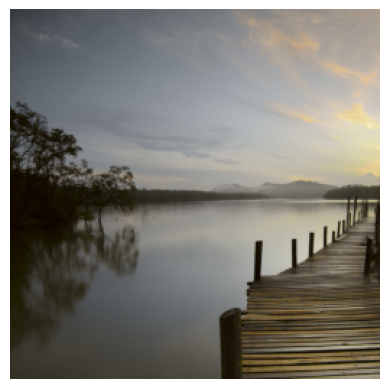

In [21]:
plt.imshow(synthesis)
plt.axis('off')

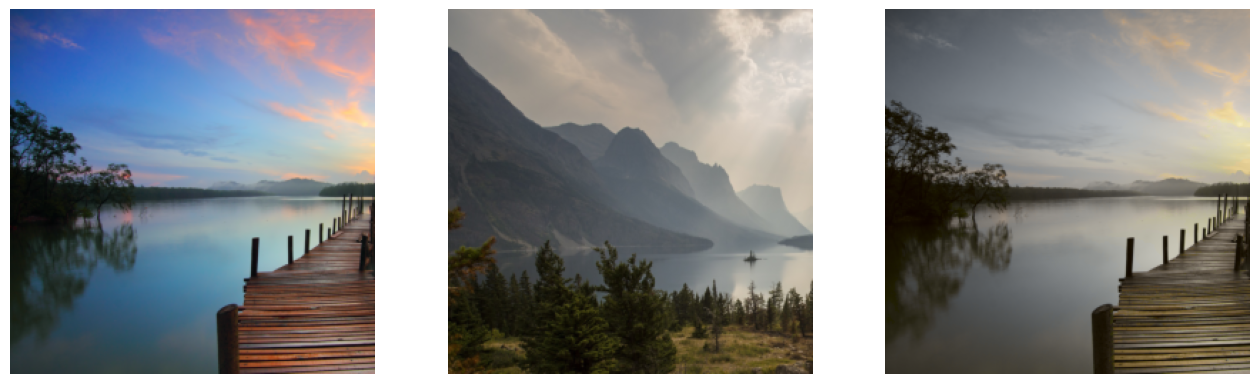

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(16, 32))
axs[0].imshow(src)
axs[1].imshow(tar)
axs[2].imshow(synthesis)
axs[0].set_axis_off()
axs[1].set_axis_off()
axs[2].set_axis_off()